# RandomForest regression for time series predict

* Ref: [https://www.kaggle.com/pbizil/random-forest-regression-for-time-series-predict](https://www.kaggle.com/pbizil/random-forest-regression-for-time-series-predict)
* Data: [https://github.com/szrlee/Stock-Time-Series-Analysis/tree/master/data](https://github.com/szrlee/Stock-Time-Series-Analysis/tree/master/data)

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')
from IPython.display import display

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import plotly.graph_objects as go

## 1. Load data

In [128]:
all_stocks =['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM',
             'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT',
             'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT', 'GOOGL', 'AMZN',
             'AABA']

url = 'https://raw.githubusercontent.com/szrlee/Stock-Time-Series-Analysis/master/data/'

list_of_df = []
for stock in all_stocks:
    df = pd.read_csv(url + stock + '_2006-01-01_to_2018-01-01.csv',
                     parse_dates=True,
                     index_col='Date')
    # Only use the open price
    df = df[['Open']].rename(columns={'Open': stock})
    list_of_df.append(df)

df = pd.concat(list_of_df, axis=1)

In [129]:
df.head()

MMM    AXP   AAPL     BA  ...    WMT   GOOGL   AMZN   AABA
Date                                    ...                             
2006-01-03  77.76  51.70  10.34  70.40  ...  46.36  211.47  47.47  39.69
2006-01-04  79.49  52.44  10.73  70.08  ...  46.24  222.17  47.48  41.22
2006-01-05  78.41  51.90  10.69  70.55  ...  46.00  223.22  47.16  40.93
2006-01-06  78.64  52.64  10.75  70.34  ...  45.69  228.66  47.97  42.88
2006-01-09  78.50  52.82  10.96  69.28  ...  45.89  233.44  46.55  43.10

[5 rows x 31 columns]

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MMM     3019 non-null   float64
 1   AXP     3019 non-null   float64
 2   AAPL    3019 non-null   float64
 3   BA      3019 non-null   float64
 4   CAT     3019 non-null   float64
 5   CVX     3019 non-null   float64
 6   CSCO    3019 non-null   float64
 7   KO      3019 non-null   float64
 8   DIS     3018 non-null   float64
 9   XOM     3019 non-null   float64
 10  GE      3019 non-null   float64
 11  GS      3019 non-null   float64
 12  HD      3019 non-null   float64
 13  IBM     3019 non-null   float64
 14  INTC    3019 non-null   float64
 15  JNJ     3019 non-null   float64
 16  JPM     3019 non-null   float64
 17  MCD     3019 non-null   float64
 18  MRK     3018 non-null   float64
 19  MSFT    3019 non-null   float64
 20  NKE     3019 non-null   float64
 21  PFE     3019 non-nu

## 2. Visualization

In [131]:
colors = ['#17BECF', '#CF1717', '#AACF17', '#17CF29', '#1742CF',
          '#B017CF', '#CF1773', '#17B0CF', '#CFA417', '#CF5E17']

def plot_time_series(df, start, end):
    fig = go.Figure()
    title = ''
    for i in range(start, end):
        j = i % 10
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df.iloc[:, i],
                                 name=df.iloc[:, i].name,
                                 line=dict(color=colors[j-1]),
                                 opacity=0.8))
        title += df.iloc[:, i].name
        if i == 8:
            title += ' and '
        if i != 8 and i!= 9:
            title += ', '

    fig.update_layout(title_text=title)
    fig.show()

In [132]:
plot_time_series(df, 0, 10)

In [133]:
plot_time_series(df, 10, 20)

In [134]:
plot_time_series(df, 20, 30)

In [135]:
plot_time_series(df, 30, 31)

## 3. Analysis

### 3.1 Correlation

* 算每一支股票今天的價位比昨天多了幾倍

In [136]:
variations = df.select_dtypes(float) / df.select_dtypes(float).shift(1) # 今天價位 / 昨天價位 = 今天的價位是昨天的幾倍
variations -= 1 # 比昨天多了或少了幾倍
variations.dropna(inplace=True)

In [137]:
variations.head()

MMM       AXP      AAPL  ...     GOOGL      AMZN      AABA
Date                                      ...                              
2006-01-04  0.022248  0.014313  0.037718  ...  0.050598  0.000211  0.038549
2006-01-05 -0.013587 -0.010297 -0.003728  ...  0.004726 -0.006740 -0.007035
2006-01-06  0.002933  0.014258  0.005613  ...  0.024371  0.017176  0.047642
2006-01-09 -0.001780  0.003419  0.019535  ...  0.020904 -0.029602  0.005131
2006-01-10  0.006369  0.014388 -0.006387  ... -0.004284 -0.003008 -0.003248

[5 rows x 31 columns]

In [138]:
variations.shape

(3011, 31)

In [139]:
variations.corr() # 每支股票彼此之間的 correlations

MMM       AXP      AAPL  ...     GOOGL      AMZN      AABA
MMM    1.000000  0.549259  0.434995  ...  0.465433  0.433634  0.350008
AXP    0.549259  1.000000  0.443845  ...  0.439788  0.401694  0.352309
AAPL   0.434995  0.443845  1.000000  ...  0.527387  0.453010  0.364544
BA     0.317827  0.287779  0.239897  ...  0.230627  0.227973  0.190126
CAT    0.573060  0.550048  0.443147  ...  0.432605  0.398221  0.348660
CVX    0.543937  0.483239  0.413226  ...  0.420755  0.365540  0.340038
CSCO   0.535934  0.503065  0.476354  ...  0.483005  0.426271  0.371933
KO     0.485659  0.432057  0.349427  ...  0.367636  0.326922  0.282941
DIS    0.565326  0.565120  0.424651  ...  0.454151  0.435608  0.361403
XOM    0.555744  0.477421  0.401401  ...  0.420181  0.380892  0.332020
GE     0.577868  0.596865  0.453959  ...  0.442533  0.399468  0.343494
GS     0.512693  0.667645  0.481453  ...  0.469614  0.404963  0.346924
HD     0.567903  0.572367  0.445346  ...  0.448291  0.457115  0.339864
IBM    0.521295  0.479522  0.470648  ...  0.456657  0.430506  0.343276
INTC   0.534837  0.522043  0.500820  ...  0.470255  0.448161  0.382461
JNJ    0.530320  0.457023  0.371472  ...  0.418293  0.372626  0.313247
JPM    0.535933  0.701787  0.450254  ...  0.452186  0.386106  0.326718
MCD    0.495027  0.455728  0.405041  ...  0.415770  0.381139  0.310962
MRK    0.417239  0.437265  0.312954  ...  0.345395  0.290615  0.233535
MSFT   0.498026  0.476178  0.443881  ...  0.501614  0.463205  0.326568
NKE    0.497521  0.476304  0.398800  ...  0.434447  0.410419  0.340435
PFE    0.483482  0.455862  0.357832  ...  0.369878  0.338966  0.280303
PG     0.478695  0.408334  0.339940  ...  0.358500  0.322552  0.287038
TRV    0.515320  0.550685  0.387841  ...  0.400142  0.351262  0.312426
UTX    0.640204  0.555532  0.462256  ...  0.488725  0.426848  0.359300
UNH    0.400688  0.381815  0.316273  ...  0.328873  0.271067  0.233087
VZ     0.506881  0.476440  0.378186  ...  0.403976  0.391406  0.289512
WMT    0.433102  0.405102  0.337956  ...  0.367865  0.345578  0.275085
GOOGL  0.465433  0.439788  0.527387  ...  1.000000  0.505898  0.388663
AMZN   0.433634  0.401694  0.453010  ...  0.505898  1.000000  0.375913
AABA   0.350008  0.352309  0.364544  ...  0.388663  0.375913  1.000000

[31 rows x 31 columns]

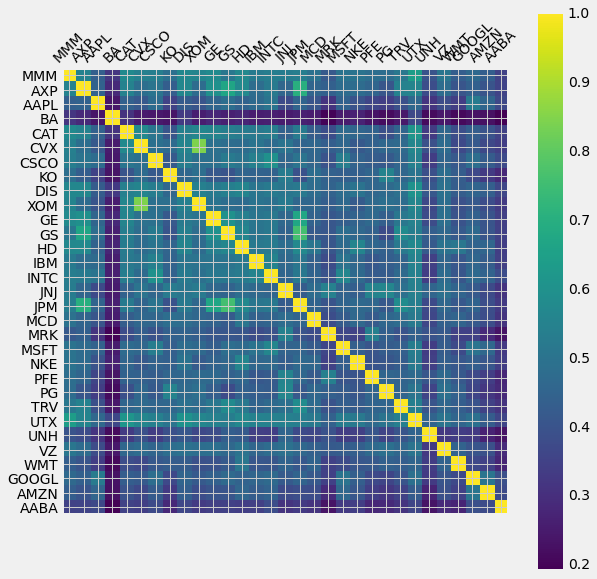

In [140]:
# 看每支股票之間的 correlations
fig = plt.figure(figsize=(10, 10))
plt.matshow(variations.corr(), fignum=fig.number)
plt.xticks(range(variations.shape[1]), variations.columns, fontsize=14, rotation=45)
plt.yticks(range(variations.shape[1]), variations.columns, fontsize=14)
c_bar = plt.colorbar()
c_bar.ax.tick_params(labelsize=14)
plt.show()

### 3.2 Stationary test

* 要預測的 time series 必須是 stationary 的，所以先用 Augumented Dicky-Fuller test 來檢查是不是 stationary

In [141]:
def stationary_test(df):
    df_stats = pd.DataFrame(columns=['p-value'], index=df.columns)

    for col in df.columns:
        adfuller_test = adfuller(df[col], autolag='AIC')
        df_stats.loc[col] = adfuller_test[1]

    return df_stats

In [142]:
def plot_p_value(df):
    fig = go.Figure(
        data=[go.Bar(x=df_stats.index,
                     y=df_stats['p-value'],
                     text=df_stats['p-value'], # 為每根 bar 都標上數值
                     textposition='auto')]
    )
    fig.show()

In [143]:
df.dropna(inplace=True)

df_stats = stationary_test(df)

In [144]:
df_stats

p-value
MMM    0.997863
AXP    0.907099
AAPL   0.987764
BA            1
CAT    0.936399
CVX    0.415025
CSCO   0.692539
KO     0.647542
DIS    0.933466
XOM    0.101893
GE      0.59505
GS     0.381287
HD            1
IBM    0.396612
INTC   0.937831
JNJ      0.9928
JPM    0.992626
MCD    0.997092
MRK    0.490979
MSFT   0.998997
NKE    0.963926
PFE    0.860195
PG     0.708768
TRV    0.990371
UTX    0.825353
UNH           1
VZ     0.509663
WMT    0.957674
GOOGL  0.996303
AMZN          1
AABA   0.989657

In [145]:
plot_p_value(df_stats)

* 全部的 $p$-value 都比 0.05 還要大，所以都不是 stationary 的
  * 要做 differencing 來變成 stationary


### 3.3 Differencing

* 先對全部的 time series 都做 differencing 然後再做 Augumented Dicky-Fuller test 檢查是否做完 differencing 後是 stationary 的

In [146]:
# df_diff = pd.DataFrame(columns=df.columns)
# df_diff['Date'] = df.index

# for col in df.columns:
#     df_diff[col] = pd.DataFrame(np.diff(df[col]))

# df_diff.dropna(inplace=True)

df_diff = df.diff()
df_diff.dropna(inplace=True) # 做過 diff() 的話第一個 row 就會是 NaN 所以要丟掉

In [147]:
df_diff.head()

MMM   AXP  AAPL    BA   CAT  ...    VZ   WMT  GOOGL  AMZN  AABA
Date                                      ...                               
2006-01-04  1.73  0.74  0.39 -0.32  0.08  ...  0.37 -0.12  10.70  0.01  1.53
2006-01-05 -1.08 -0.54 -0.04  0.47  1.07  ...  0.71 -0.24   1.05 -0.32 -0.29
2006-01-06  0.23  0.74  0.06 -0.21  0.45  ...  0.32 -0.31   5.44  0.81  1.95
2006-01-09 -0.14  0.18  0.21 -1.06  0.98  ... -0.21  0.20   4.78 -1.42  0.22
2006-01-10  0.50  0.76 -0.07 -0.48  0.90  ...  0.41 -0.39  -1.00 -0.14 -0.14

[5 rows x 31 columns]

In [165]:
df_stats = stationary_test(df_diff)

In [163]:
df_stats

p-value
MMM              0
AXP              0
AAPL   2.54812e-20
BA               0
CAT              0
CVX    4.27651e-27
CSCO             0
KO               0
DIS    1.12314e-16
XOM    6.62594e-22
GE     3.32356e-25
GS     1.79447e-20
HD               0
IBM              0
INTC             0
JNJ              0
JPM              0
MCD    6.22889e-22
MRK              0
MSFT   2.04056e-30
NKE    5.19493e-19
PFE              0
PG               0
TRV    1.77494e-22
UTX              0
UNH              0
VZ               0
WMT    6.79667e-28
GOOGL  5.64892e-19
AMZN    1.2673e-17
AABA             0

In [149]:
plot_p_value(df_stats)

* 經過 differencing 之後，全部的 time series 的 $p$-value 都比 0.05 小, 所以全都變成 stationary 的了
* 把經過 differencing 之後的 time series 畫出來
  * 隨便選一個來畫，這邊畫 index=1 的那一個

In [150]:
# fig = go.Figure()
# fig.add_trace(
#     go.Scatter(
#         x=df_diff.index,
#         y=df_diff.iloc[:, 1],
#         name=df_diff.iloc[:, 1].name,
#         line=dict(color=colors[0]),
#         opacity=0.8
#     )
# )
# fig.show()

plot_time_series(df_diff, 1, 2)

## 4. Auto ARIMA model

In [151]:
from datetime import datetime, timedelta

def train_test_split(time_series, start_date, end_date):
    date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=1)
    date = date.strftime('%Y-%m-%d')

    train = time_series.loc[time_series.index < date]
    test = time_series.loc[start_date : end_date]

    return train, test

In [152]:
# train = df_diff['AAPL'].loc[df_diff.index < '2016-12-31']
# test = df_diff['AAPL'].loc['2017-01-01':'2017-01-31']

train, test = train_test_split(df_diff['AAPL'], '2017-01-01', '2017-01-31')

In [154]:
print(type(train))
print(train)

<class 'pandas.core.series.Series'>
Date
2006-01-04    0.39
2006-01-05   -0.04
2006-01-06    0.06
2006-01-09    0.21
2006-01-10   -0.07
              ... 
2016-12-23   -0.76
2016-12-27    0.93
2016-12-28    1.00
2016-12-29   -1.07
2016-12-30    0.20
Name: AAPL, Length: 2765, dtype: float64


In [155]:
print(type(test))
print(test)

<class 'pandas.core.series.Series'>
Date
2017-01-03   -0.85
2017-01-04    0.05
2017-01-05    0.07
2017-01-06    0.86
2017-01-09    1.17
2017-01-10    0.82
2017-01-11   -0.03
2017-01-12    0.16
2017-01-13    0.21
2017-01-17   -0.77
2017-01-18    1.66
2017-01-19   -0.60
2017-01-20    1.05
2017-01-23   -0.45
2017-01-24   -0.45
2017-01-25    0.87
2017-01-26    1.25
2017-01-27    0.47
2017-01-30   -1.21
2017-01-31    0.22
Name: AAPL, dtype: float64


In [62]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 3.4MB/s 
     |████████████████████████████████| 2.1MB 17.2MB/s 
     |████████████████████████████████| 808kB 33.7MB/s 
     |████████████████████████████████| 8.7MB 9.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [156]:
from pmdarima.arima import auto_arima

time_series = df_diff['AAPL']

stepwise_model = auto_arima(
    time_series,
    start_p=1, max_p=3,
    d=1,
    start_q=1, max_q=3,
    D=1,
    m=12, # 每 12 個為一週期
    seasonal=True,
    trace=True, # 會輸出每個 ARIMA(p,d,q)(P,D,Q)[S] 的 AIC 的結果
    error_action='ignore', # 並不是全部的 ARIMA(p, d, q)(P, D, Q)[S] 組合都能跑，有些組合有問題
    suppress_warning=True, # 所以當遇到問題時 error_action 指明要 ignore
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=29.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14597.318, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12630.987, Time=1.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=23.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13450.441, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12270.103, Time=4.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=59.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=21.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=13443.588, Time=2.86 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11879.917, Time=5.41 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=12209.960, Time=2.16 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=66.61 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=38.00 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=11663.820, Time=6.41 sec
 ARIMA(3,1,0)(1,1,0)[12]           

In [157]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3015
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -5825.910
Date:                            Sun, 04 Oct 2020   AIC                          11663.820
Time:                                    20:57:05   BIC                          11699.862
Sample:                                         0   HQIC                         11676.784
                                           - 3015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8619      0.010    -90.197      0.000      -0.881      -0.843
ar.L2         -0.5541      0.012    -45.091      0.000      -0.578      -0.530
ar.L3         -0.2652      0.011    -23.808      0.000      -0.287      -0.243
ar.S.L12      -0.6481      0.010    -63.965      0.000      -0.668      -0.628
ar.S.L24      -0.3229      0.010    -33.084      0.000      -0.342      -0.304
sigma2         2.8326      0.028     99.995      0.000       2.777       2.888
===================================================================================
Ljung-Box (Q):                      747.13   Jarque-Bera (JB):             60138.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.88   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [166]:
stepwise_model.fit(train)
arima_pred = stepwise_model.predict(n_periods=len(test))

In [167]:
print(type(arima_pred))
print(arima_pred)

<class 'numpy.ndarray'>
[-0.03018244 -0.1115633  -1.23136467 -0.78011848 -0.85564706 -0.11810565
  0.22023039 -0.79723314  0.52961016  0.97081688 -0.69709081 -0.15260638
 -0.07882441 -0.57739209 -0.26757889 -1.33054686 -0.82512837 -0.19584526
 -0.66439271 -1.04552298]


In [169]:
# df_pred = pd.DataFrame(pred, index=test.index, columns=['AAPL'])
df_pred = pd.DataFrame(test.values,
                       index=test.index,
                       columns=['AAPL_true'])
df_pred['AAPL_pred'] = arima_pred

In [170]:
df_pred

AAPL_true  AAPL_pred
Date                            
2017-01-03      -0.85  -0.030182
2017-01-04       0.05  -0.111563
2017-01-05       0.07  -1.231365
2017-01-06       0.86  -0.780118
2017-01-09       1.17  -0.855647
2017-01-10       0.82  -0.118106
2017-01-11      -0.03   0.220230
2017-01-12       0.16  -0.797233
2017-01-13       0.21   0.529610
2017-01-17      -0.77   0.970817
2017-01-18       1.66  -0.697091
2017-01-19      -0.60  -0.152606
2017-01-20       1.05  -0.078824
2017-01-23      -0.45  -0.577392
2017-01-24      -0.45  -0.267579
2017-01-25       0.87  -1.330547
2017-01-26       1.25  -0.825128
2017-01-27       0.47  -0.195845
2017-01-30      -1.21  -0.664393
2017-01-31       0.22  -1.045523

* 比較原本的和 Auto-ARIMA 預測的結果

In [171]:
fig = go.Figure()
# true
fig.add_trace(
    go.Scatter(
        x=df_pred.index,
        y=df_pred['AAPL_true'].values,
        name='AAPL - Original',
        line=dict(color=colors[0]),
        opacity=0.8
    )
)
# predicted
fig.add_trace(
    go.Scatter(
        x=df_pred.index,
        y=df_pred['AAPL_pred'].values,
        name='AAPL - Forecasted',
        line=dict(color=colors[1]),
        opacity=0.8
    )
)
fig.show()

In [172]:
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(df_pred['AAPL_true'].values,
                          df_pred['AAPL_pred'].values)
r2 = r2_score(df_pred['AAPL_true'].values,
              df_pred['AAPL_pred'].values)
print(f'Auto ARIMA model: mae={mae}, r2_score={r2}')

Auto ARIMA model: mae=1.0575140055832901, r2_score=-1.7663713254081679


## 5. RandomForest Regression

* 因為要用 RandomForest 的話就需要好幾個 features，所以要自己檢查哪些是可以用來當 features 的東西，然後自己建立 features

### 5.1 Lags

* 因為做 time series 所以一定需要 lags 來當 feature，只是要用幾個 lags?
  * 先選比較多的 lags 然後做 fitting 再看 feature importance 。這樣就能知道哪幾個 lags 是比較會影響結果的，最後就只用那幾個 lags

In [173]:
df_lags = pd.DataFrame()

n_lags = 10 # 暫時用 10 個 lags 試試看

for i in range(n_lags, 0, -1):
    df_lags['t_' + str(i)] = df_diff['AAPL'].shift(i)
df_lags['t'] = df_diff['AAPL'].values

# 因為做了 shift() 所以會有 NaN 的部分，要把這些拿掉
df_lags.dropna(inplace=True)

In [174]:
df_lags.head()

t_10   t_9   t_8   t_7   t_6   t_5   t_4   t_3   t_2   t_1     t
2006-01-19  0.39 -0.04  0.06  0.21 -0.07  1.09  0.16  0.00  0.10 -0.37 -0.26
2006-01-20 -0.04  0.06  0.21 -0.07  1.09  0.16  0.00  0.10 -0.37 -0.26 -0.28
2006-01-23  0.06  0.21 -0.07  1.09  0.16  0.00  0.10 -0.37 -0.26 -0.28 -0.46
2006-01-24  0.21 -0.07  1.09  0.16  0.00  0.10 -0.37 -0.26 -0.28 -0.46  0.38
2006-01-25 -0.07  1.09  0.16  0.00  0.10 -0.37 -0.26 -0.28 -0.46  0.38 -0.19

In [175]:
array = df_lags.values
X = array[:, :-1]
y = array[:, -1]

In [177]:
print(type(X), X.shape)
print(X)

<class 'numpy.ndarray'> (3005, 10)
[[ 0.39 -0.04  0.06 ...  0.    0.1  -0.37]
 [-0.04  0.06  0.21 ...  0.1  -0.37 -0.26]
 [ 0.06  0.21 -0.07 ... -0.37 -0.26 -0.28]
 ...
 [ 2.95  0.35 -0.1  ... -0.7   0.51 -3.88]
 [ 0.35 -0.1   1.23 ...  0.51 -3.88 -0.7 ]
 [-0.1   1.23  1.25 ... -3.88 -0.7   0.9 ]]


In [178]:
print(type(y), y.shape)
print(y)

<class 'numpy.ndarray'> (3005,)
[-0.26 -0.28 -0.46 ... -0.7   0.9  -0.48]


In [179]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=500,
                                 random_state=1)
rf_model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

* 畫 feature importance 看哪幾個 lags 比較重要

In [180]:
fig = go.Figure(
    data=[go.Bar(x=df_lags.columns,
                 y=rf_model.feature_importances_,
                 text=rf_model.feature_importances_,
                 textposition='auto')]
)
fig.show()

* 這邊是藉由 feature importance 來看哪幾個 lags 才是真的重要的
  * 前四個最重要的是 t_1, t_2, t_7, t_3

In [181]:
from sklearn.feature_selection import RFE # recursive feature elimination 

rfe = RFE(RandomForestRegressor(n_estimators=500,
                                random_state=1),
          4) # 選出前四個重要的 features
fit = rfe.fit(X, y)

col_names = df_lags.columns
columns = []
for i in range(len(fit.support_)):
    if fit.support_[i]:
        columns.append(col_names[i])

print('Columns with predictive power:', columns)

Columns with predictive power: ['t_7', 't_3', 't_2', 't_1']


* 這邊是藉由 feature selection 來選出重要的 lags
  * 也找出前四名是 t_7, t_3, t_2, t_1

### 5.2 Seasonality

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.values, model='additive', period=1)

In [184]:
print(type(result.seasonal), result.seasonal.shape)
print(result.seasonal)

<class 'numpy.ndarray'> (3016, 31)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [188]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=result.seasonal,
        mode='lines',
        name='Seasonal - AAPL'
    )
)
fig.show()

* Seasonal 的部分全都是 0，這表示 seasonality 不能拿來當 feature

### 5.3 Rolling mean

In [189]:
df_rolling = pd.DataFrame(columns=df.columns)

n = 80 # 用 80 個數來算 rolling mean
for col in df.columns:
    df_rolling[col] = df[col].rolling(window=n).mean()

df_rolling.dropna(inplace=True) # 因為算 rolling mean, 所以前 n 個 rows 都會是 NaN，要刪掉

In [190]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df.index,
               y=df['AAPL'],
               mode='lines',
               name='AAPL')
)
fig.add_trace(
    go.Scatter(x=df.index,
               y=df_rolling['AAPL'],
               mode='lines',
               name='AAPL - rolling mean')
)
fig.show()

### 5.4 RandomForest model

* 用 lags, diff, rolling mean 當作 features
* 先只看一支股票，所以選 Apple 來看


In [192]:
df_forecast = pd.DataFrame(df['AAPL'])
# 加入 lags feature, 用 t_1, t_2, t_3, t_7
df_forecast['t_1'] = df_lags['t_1']
df_forecast['t_2'] = df_lags['t_2']
df_forecast['t_3'] = df_lags['t_3']
df_forecast['t_7'] = df_lags['t_7']
# 加入 diff feature
df_forecast['diff'] = df_diff['AAPL']
# 加入 rolling mean feature
df_forecast['rolling_mean'] = df_rolling['AAPL']

df_forecast.dropna(inplace=True) # 因為會有 NaN 所以要拿掉

In [193]:
df_forecast.head()

AAPL   t_1   t_2   t_3   t_7  diff  rolling_mean
Date                                                         
2006-04-27   9.68  0.10 -0.13 -0.19 -0.21  0.16      9.972000
2006-04-28   9.91  0.16  0.10 -0.13  0.26  0.23      9.966625
2006-05-01  10.11  0.23  0.16  0.10  0.38  0.20      9.958875
2006-05-02  10.02  0.20  0.23  0.16 -0.19 -0.09      9.950500
2006-05-03  10.26 -0.09  0.20  0.23 -0.19  0.24      9.944375

In [196]:
from sklearn.metrics import mean_absolute_error

X = df_forecast.iloc[:, 1:] # 除了 AAPL 以外的欄位
y = df_forecast.iloc[:, 0] # 就是 AAPL 欄位

X_train = X.loc[X.index < '2017-10-01'].values
y_train = y.loc[y.index < '2017-10-01'].values

X_test = X.loc[X.index >= '2017-10-01'].values
y_test = y.loc[y.index >= '2017-10-01'].values

In [197]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (2874, 6)
<class 'numpy.ndarray'> (2874,)
<class 'numpy.ndarray'> (63, 6)
<class 'numpy.ndarray'> (63,)


In [201]:
print('X_train:\n', X_train)
print('y_train:\n', y_train)
print('X_test:\n', X_test)
print('y_test:\n', y_test)

X_train:
 [[ 1.00000000e-01 -1.30000000e-01 -1.90000000e-01 -2.10000000e-01
   1.60000000e-01  9.97200000e+00]
 [ 1.60000000e-01  1.00000000e-01 -1.30000000e-01  2.60000000e-01
   2.30000000e-01  9.96662500e+00]
 [ 2.30000000e-01  1.60000000e-01  1.00000000e-01  3.80000000e-01
   2.00000000e-01  9.95887500e+00]
 ...
 [ 1.79000000e+00 -1.55000000e+00 -4.26000000e+00  1.64000000e+00
   2.02000000e+00  1.53460875e+02]
 [ 2.02000000e+00  1.79000000e+00 -1.55000000e+00 -6.00000000e-01
   9.00000000e-02  1.53455250e+02]
 [ 9.00000000e-02  2.02000000e+00  1.79000000e+00 -1.61000000e+00
  -6.80000000e-01  1.53446625e+02]]
y_train:
 [  9.68   9.91  10.11 ... 153.8  153.89 153.21]
X_test:
 [[-6.80000000e-01  9.00000000e-02  2.02000000e+00 -2.10000000e+00
   1.05000000e+00  1.53437125e+02]
 [ 1.05000000e+00 -6.80000000e-01  9.00000000e-02 -4.26000000e+00
  -2.50000000e-01  1.53421625e+02]
 [-2.50000000e-01  1.05000000e+00 -6.80000000e-01 -1.55000000e+00
  -3.80000000e-01  1.53402125e+02]
 [-3.800

In [202]:
rf_model = RandomForestRegressor(n_estimators=500)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [207]:
print(type(y_pred), y_pred.shape)
print(y_pred)

<class 'numpy.ndarray'> (63,)
[155.17818 158.78508 158.69322 156.14336 156.94854 157.0728  156.72256
 156.42138 156.53348 156.91496 156.9285  157.35584 157.1049  156.21718
 155.5593  154.52046 156.32196 156.76204 156.7989  156.92354 156.67816
 156.78766 156.47144 156.28656 155.37476 154.8873  155.50396 155.0668
 156.28054 156.39582 156.33166 156.33404 154.53212 155.24744 154.98406
 156.12854 156.3957  156.55864 157.0241  156.5897  156.10776 156.44794
 155.9155  154.10836 154.09478 156.2753  155.6347  153.74448 155.08248
 156.49372 156.12114 155.63744 155.97452 156.30362 157.19142 157.0446
 156.33542 156.47976 156.8998  156.56784 155.74454 154.57834 156.42724]


In [206]:
train_index = y.loc[y.index < '2017-10-01'].index

fig = go.Figure()
# true
fig.add_trace(
    go.Scatter(x=train_index,
               y=y_train,
               mode='lines',
               name='AAPL - train')
)
fig.add_trace(
    go.Scatter(x=test_index,
               y=y_test,
               mode='lines',
               name='AAPL - observed')
)
# predict
fig.add_trace(
    go.Scatter(x=test_index,
               y=y_pred,
               mode='lines',
               name='AAPL - predicted')
)
fig.show()

In [208]:
test_index = y.loc[y.index >= '2017-10-01'].index

fig = go.Figure()
# true
fig.add_trace(
    go.Scatter(x=test_index,
               y=y_test,
               mode='lines',
               name='AAPL - true')
)
# predicted
fig.add_trace(
    go.Scatter(x=test_index,
               y=y_pred,
               mode='lines',
               name='AAPL - predicted')
)
fig.show()

In [209]:
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RandomForest model: mae={mae}, r2_score={r2}')

RandomForest model: mae=11.34119301587286, r2_score=-2.154045162209379


* 結果用 RandomForest 得到的 mae 和 $R^2$ score 比 Auto-ARIMA 的還要差
* 計算每個欄位的 mean squared log error

In [226]:
from sklearn.metrics import mean_squared_log_error

X = df_forecast.iloc[:, 1:] # 除了 AAPL 以外的欄位
y = df_forecast.iloc[:, 0] # 就是 AAPL 欄位

X_train = X.loc[X.index < '2017-10-01']
y_train = y.loc[y.index < '2017-10-01']

X_test = X.loc[X.index >= '2017-10-01']
y_test = y.loc[y.index >= '2017-10-01']

min_error = 1000
min_var = None

for var in X.columns:
    rf_model = RandomForestRegressor(n_estimators=500,
                                     random_state=0,
                                     n_jobs=-1)
    rf_model.fit(X_train[[var]], y_train)
    y_pred = rf_model.predict(X_test[[var]])

    error = np.sqrt(mean_squared_log_error(y_test, y_pred)) * 100
    print(f'Variable {var}: Error={error}')

    if error < min_error:
        min_var = var
        min_error = error

print(f'The minimum var={min_var} error={min_error}')

Variable t_1: Error=94.2388430195829
Variable t_2: Error=94.77076957147167
Variable t_3: Error=94.43539791934785
Variable t_7: Error=93.17065098876455
Variable diff: Error=95.57064811654675
Variable rolling_mean: Error=8.223182347854275
The minimum var=rolling_mean error=8.223182347854275


### 5.5 RandomForest model for all stocks

* 把 5.4 節的東西包裝起來，變成可以套用到任何的股票

In [227]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

r2_score = []
mae = []
df_pred = pd.DataFrame()

for col in df.columns:
    # 準備要用來 fitting 的 dataframe
    df_forecast = pd.DataFrame(df[col])
    # 加入 lags feature, 用 t_1, t_2, t_3, t_7
    df_forecast['t_1'] = df_lags['t_1']
    df_forecast['t_2'] = df_lags['t_2']
    df_forecast['t_3'] = df_lags['t_3']
    df_forecast['t_7'] = df_lags['t_7']
    # 加入 diff feature
    df_forecast['diff'] = df_diff[col]
    # 加入 rolling mean feature
    df_forecast['rolling_mean'] = df_rolling[col]
    
    df_forecast.dropna(inplace=True) # 因為會有 NaN 所以要拿掉

    # train test split
    X = df_forecast.iloc[:, 1:]
    y = df_forecast.iloc[:, 0]

    X_train = X.loc[X.index < '2017-10-01']
    y_train = y.loc[y.index < '2017-10-01']

    X_test = X.loc[X.index >= '2017-10-01']
    y_test = y.loc[y.index >= '2017-10-01']

    # RF model
    rf_model = RandomForestRegressor(n_estimators=500)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    df_pred[col + '_true'] = y_test.values
    df_pred[col + '_pred'] = y_pred

    # metric
    error = mean_absolute_error(y_test, y_pred)
    score = rf_model.score(X_test, y_test)
    mae.append([col, error])
    r2_score.append([col, score])

df_pred = df_pred.set_index(y_test.index)

df_mae = pd.DataFrame(mae, columns=['Stock', 'MAE'])
df_mae.set_index('Stock')

df_score = pd.DataFrame(r2_score, columns=['Stock', 'R2_score'])
df_score.set_index('Stock', inplace=True)

In [228]:
df_pred.head()

MMM_true   MMM_pred  AXP_true  ...  AMZN_pred  AABA_true  AABA_pred
Date                                       ...                                 
2017-10-02    210.73  210.82932     90.44  ...  959.08246      66.60   66.04514
2017-10-03    212.62  211.14524     90.59  ...  955.92984      67.19   65.99518
2017-10-04    214.85  210.52518     91.60  ...  962.44022      67.79   66.05708
2017-10-05    216.49  210.36908     90.96  ...  969.96128      67.75   65.85016
2017-10-06    216.00  210.15656     91.25  ...  968.99678      67.49   65.78040

[5 rows x 62 columns]

In [229]:
df_mae

Stock         MAE
0     MMM   19.617723
1     AXP    6.914917
2    AAPL   11.278097
3      BA   16.540555
4     CAT   14.039698
5     CVX    5.990459
6    CSCO    3.451428
7      KO    0.512297
8     DIS    4.640898
9     XOM    2.653067
10     GE    3.766226
11     GS   15.849291
12     HD   18.188550
13    IBM    6.934784
14   INTC    7.767368
15    JNJ    7.653731
16    JPM    6.317122
17    MCD   10.362776
18    MRK    4.902696
19   MSFT    8.059868
20    NKE    3.674774
21    PFE    1.757075
22     PG    2.161565
23    TRV    9.435524
24    UTX    3.308497
25    UNH   17.196650
26     VZ    2.357301
27    WMT    9.970771
28  GOOGL   92.017294
29   AMZN  125.640035
30   AABA    3.756504

In [230]:
df_score

R2_score
Stock           
MMM    -5.143480
AXP    -5.388923
AAPL   -2.120858
BA     -1.325332
CAT    -2.826520
CVX    -4.220685
CSCO   -3.363516
KO     -0.894256
DIS    -0.560859
XOM    -9.286539
GE     -1.810550
GS     -4.388369
HD     -3.829034
IBM    -3.630764
INTC   -8.097887
JNJ    -6.511863
JPM    -2.448074
MCD    -4.435606
MRK    -1.319003
MSFT   -4.978498
NKE    -0.151497
PFE   -11.095781
PG     -0.837431
TRV    -6.488215
UTX    -0.768854
UNH    -3.026809
VZ     -0.084444
WMT    -2.107125
GOOGL  -9.659057
AMZN   -2.255962
AABA   -4.029548

In [231]:
fig = go.Figure(
    data=[go.Bar(x=df_score.index,
                 y=df_score['R2_score'],
                 text=df_score['R2_score'],
                 textposition='auto')]
)
fig.show()

In [235]:
print('Max is:', df_score[df_score['R2_score']==df_score.max()[0]].index)
print('Min is:', df_score[df_score['R2_score']==df_score.min()[0]].index)

Max is: Index(['VZ'], dtype='object', name='Stock')
Min is: Index(['PFE'], dtype='object', name='Stock')


* 畫出最好的 VZ 和最壞的 PEE 的 time series

In [236]:
test_index = df_pred.index

fig = go.Figure()
# true
fig.add_trace(
    go.Scatter(x=test_index,
               y=df_pred['VZ_true'],
               mode='lines',
               name='VZ - observed')
)
# predicted
fig.add_trace(
    go.Scatter(x=test_index,
               y=df_pred['VZ_pred'],
               mode='lines',
               name='VZ - predicted')
)
fig.show()

In [237]:
test_index = df_pred.index

fig = go.Figure()
# true
fig.add_trace(
    go.Scatter(x=test_index,
               y=df_pred['PFE_true'],
               mode='lines',
               name='PFE - observed')
)
# predict
fig.add_trace(
    go.Scatter(x=test_index,
               y=df_pred['PFE_pred'],
               mode='lines',
               name='PFE - predicted')
)
fig.show()